In [1]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

logging.basicConfig(level=logging.INFO, format='%(levelname)-8s %(message)s')
logger = logging.getLogger('Sim')

In [2]:
usdc_pool_0 = 30_000_000 # 30 million USDC in SyncSwap pool initially
eth_pool_0 = 16_000 # 16 thousand ETH in SyncSwap pool initially
initial_price = usdc_pool_0 / eth_pool_0
logger.info(f'Initial SyncSwap ETH/USDC price = {usdc_pool_0 / eth_pool_0}')
logger.info(f'Pool TVL = ${usdc_pool_0 * 2 / 1e6} million\n')

eth_lp_amount = 1 # User LPs 10 ETH
usdc_lp_amount = (usdc_pool_0 / eth_pool_0) * eth_lp_amount
logger.info(f'User 1 LPs {eth_lp_amount} ETH. User 2 LPs {usdc_lp_amount} USDC.')
user_pool_share = eth_lp_amount / (eth_pool_0 + eth_lp_amount)
logger.info(f'Users together own {user_pool_share * 100}% of the total pool')

syncswap_apr = 0.11 # 11% is a conservative APR estimate
reactorfusion_usdc_apr = 0.065 # 6.5% net APR is a high estimate
reactorfusion_eth_apr = 0.045 # 4.5% net APR is a high estimate

INFO     Initial SyncSwap ETH/USDC price = 1875.0
INFO     Pool TVL = $60.0 million

INFO     User 1 LPs 1 ETH. User 2 LPs 1875.0 USDC.
INFO     Users together own 0.006249609399412537% of the total pool


In [3]:
# There are multiple ways of generating a random final state. This is a simple one.
# Allow the final USDC (and ETH) pool amount to be up to 50% different from the current one
# We sample uniformly from this distribution to deliberately oversample unlikely big changes
# (since those are the potentially problematic edge cases)
n = 1000 # Number of samples
diff_threshold = 0.4

usdc_pool_f_arr = np.rint(usdc_pool_0 * (2 * np.random.random(n) * diff_threshold - diff_threshold + 1))
eth_pool_f_arr = np.rint(eth_pool_0 * (2 * np.random.random(n) * diff_threshold - diff_threshold + 1))

_len = 4
logger.info('First few simulated end results:')
logger.info(f'USDC pool amounts = {usdc_pool_f_arr[:_len]}')
logger.info(f'ETH pool amounts = {eth_pool_f_arr[:_len]}')
logger.info(f'ETH/USDC prices = {np.rint(usdc_pool_f_arr / eth_pool_f_arr)[:_len]}')
logger.info(f'Pool TVLs = ${usdc_pool_f_arr[:_len] * 2 / 1e6} million')

INFO     First few simulated end results:
INFO     USDC pool amounts = [29654313. 35449305. 33580379. 41267948.]
INFO     ETH pool amounts = [13660. 10296. 14050. 18526.]
INFO     ETH/USDC prices = [2171. 3443. 2390. 2228.]
INFO     Pool TVLs = $[59.308626 70.89861  67.160758 82.535896] million


In [4]:
"""
Note that we can break down any change in pool composition into a single (1) add/remove liquidity + (2) swap
Swaps do not change a user's pool share (since fundamentally there is no change in LP). And they keep x * y = k.
So we pretend that the add/remove liquidity comes first (makes calculating pool share difference easy)
and then account for the swap that brings us to our final pool amounts.

Did some math, here is the result:
After the add/remove liquidity, x_mid = sqrt(price_0 * k_f) and y_mid = k_f / x_mid
So (x_mid - x0) liquidity is added of token1 and (y_mid - y0) of token 2 at our initial price
"""
def simulate(
    pool_token1_initial_amount, pool_token2_initial_amount,
    user_token1_lp_amount, user_token2_lp_amount,
    pool_token1_final_amount, pool_token2_final_amount,
    dex_apr, lending_token1_apr, lending_token2_apr,
    token1_name = "token1", token2_name = "token2"
):
    initial_price = pool_token1_initial_amount / pool_token2_initial_amount
    logger.info(f'Initial pool composition: {pool_token1_initial_amount} {token1_name}, '
          f'{pool_token2_initial_amount} {token2_name}')
    logger.info(f'Initial price of {token2_name}/{token1_name} = {initial_price}\n')
    assert(np.isclose(initial_price, user_token1_lp_amount / user_token2_lp_amount))
    
    pool_token1_initial_amount += user_token1_lp_amount
    pool_token2_initial_amount += user_token2_lp_amount
    
    initial_user_pool_share = user_token1_lp_amount / pool_token1_initial_amount
    assert(np.isclose(initial_user_pool_share, user_token2_lp_amount / pool_token2_initial_amount))
    logger.info(f'1. Alice and Bob LP {user_token1_lp_amount} {token1_name} and {user_token2_lp_amount} {token2_name}')
    logger.info(f'   Initially, they own {initial_user_pool_share * 100}% of the total pool')
        
    k_f = pool_token1_final_amount * pool_token2_final_amount
    
    # Pool composition after the add/remove liquidity and before the swap
    pool_token1_intermediate_amount = np.sqrt(initial_price * k_f)
    pool_token2_intermediate_amount = k_f / pool_token1_intermediate_amount
    
    token1_liquidity_delta = pool_token1_intermediate_amount - pool_token1_initial_amount
    token2_liquidity_delta = pool_token2_intermediate_amount - pool_token2_initial_amount
    logger.info(f'2. Other users {"added" if token1_liquidity_delta > 0 else "removed"} liquidity: '
          f'{np.round(np.abs(token1_liquidity_delta), 2)} {token1_name}, '
          f'{np.round(np.abs(token2_liquidity_delta), 2)} {token2_name}')
    
    token1_swap_delta = pool_token1_final_amount - pool_token1_intermediate_amount
    token2_swap_delta = pool_token2_final_amount - pool_token2_intermediate_amount
    final_price = pool_token1_final_amount / pool_token2_final_amount
    logger.info(f'3. Other users {"sold" if token1_swap_delta > 0 else "bought"} '
          f'{np.round(np.abs(token1_swap_delta), 2)} {token1_name} for '
          f'{np.round(np.abs(token2_swap_delta))} {token2_name}\n')
    logger.info(f'Final pool composition: {pool_token1_final_amount} {token1_name}, '
      f'{pool_token2_final_amount} {token2_name}')
    logger.info(f'Final price of {token2_name}/{token1_name} = {np.round(final_price, 2)}')
    final_user_pool_share = user_token1_lp_amount / pool_token1_intermediate_amount
    assert(np.isclose(final_user_pool_share, user_token2_lp_amount / pool_token2_intermediate_amount))
    logger.info(f'Ultimately, the specified LPs own {final_user_pool_share * 100}% of the total pool\n')

    # Specific profit analysis below
    lending_token1_out = user_token1_lp_amount * (1 + lending_token1_apr)
    lending_token2_out = user_token2_lp_amount * (1 + lending_token2_apr)
    logger.info(f'Benchmark = ReactorFusion pools: Assume {lending_token1_apr * 100}% APR on'
          f' {token1_name} and {lending_token2_apr * 100}% APR on {token2_name}')
    logger.info(f'Simply lending in ReactorFusion would yield '
          f'{np.round(lending_token1_out, 2)} {token1_name} and '
          f'{np.round(lending_token2_out, 2)} {token2_name}\n')
    
    logger.info(f'Assume a conservative {dex_apr * 100}% APR on the SyncSwap {token1_name}/{token2_name} pool')
    withdraw_token1_amount = final_user_pool_share * pool_token1_final_amount * (1 + syncswap_apr)
    withdraw_token2_amount = final_user_pool_share * pool_token2_final_amount * (1 + syncswap_apr)
    unbalanced_token1_amount = withdraw_token1_amount
    unbalanced_token2_amount = withdraw_token2_amount
    logger.info(f'Without a rebalancing mechanism, Alice and Bob withdraw '
          f'{np.round(withdraw_token1_amount, 2)} {token1_name}'
          f' and {np.round(withdraw_token2_amount, 2)} {token2_name} from SyncSwap\n')
    
    # Now we will swap token1 for token2 or vice versa so that both sides are the same percentage better
    # than our benchmark. For example, if the benchmark yield is 1 ETH and 2000 USDC, we will swap so that
    # we are at 1.03 ETH and 2060 USDC (approximately)
    # https://www.wolframalpha.com/input?i2d=true&i=solve+for+d+in+%5C%2840%29s+-+d%5C%2841%29b++%3D+%5C%2840%29t+%2B++Divide%5B%5C%2840%291+-+0.003%5C%2841%29+*+d+*+y%2Cx%5D+%5C%2841%29a
    will_swap_token1_for_token2 = withdraw_token1_amount > lending_token1_out and \
        withdraw_token1_amount / lending_token1_out > withdraw_token2_amount / lending_token2_out
    will_swap_token2_for_token1 = withdraw_token2_amount > lending_token2_out and \
        withdraw_token2_amount / lending_token2_out > withdraw_token1_amount / lending_token1_out
    if (will_swap_token1_for_token2):
        # This equation is a good approximation (just doesn't account for price impact,
        # so we very reasonably assume the swap is small compared to the size of the pool),
        # but we should sanity check it before doing the swap
        numer = 1000 * pool_token1_final_amount * \
            (lending_token2_out * withdraw_token1_amount - lending_token1_out * withdraw_token2_amount)
        denom = (997 * lending_token1_out * pool_token2_final_amount +
                 1000 * lending_token2_out * pool_token1_final_amount)
        swap_token1_amount_in = numer / denom
        # We will query pool balances in the smart contract call before doing the swap,
        # so there must be zero slippage
        estimated_token2_amount_out = 0.997 * swap_token1_amount_in * pool_token2_final_amount \
            / (pool_token1_final_amount + swap_token1_amount_in)
        withdraw_token1_amount -= swap_token1_amount_in
        withdraw_token2_amount += estimated_token2_amount_out
        logger.info(f'Rebalancing mechanism: We swap {np.round(swap_token1_amount_in, 2)} {token1_name} '
              f'for {np.round(estimated_token2_amount_out, 2)} {token2_name}')
    elif will_swap_token2_for_token1:
        numer = 1000 * pool_token2_final_amount * \
            (lending_token1_out * withdraw_token2_amount - lending_token2_out * withdraw_token1_amount)
        denom = (997 * lending_token2_out * pool_token1_final_amount +
                 1000 * lending_token1_out * pool_token2_final_amount)
        swap_token2_amount_in = numer / denom
        # We will query pool balances in the smart contract call before doing the swap,
        # so there must be zero slippage
        estimated_token1_amount_out = 0.997 * swap_token2_amount_in * pool_token1_final_amount \
            / (pool_token2_final_amount + swap_token2_amount_in)
        withdraw_token1_amount += estimated_token1_amount_out
        withdraw_token2_amount -= swap_token2_amount_in
        logger.info(f'Rebalancing mechanism: We swap {np.round(swap_token2_amount_in, 2)} {token2_name} '
              f'for {np.round(estimated_token1_amount_out, 2)} {token1_name}')
    else:
        logger.info('Unexpected, the benchmark performed better on both tokens. '
              'Is the DEX APY higher than the lending APY?')
        assert(false)
    logger.info(f'After the rebalancing mechanism, Alice withdraws '
      f'{np.round(withdraw_token1_amount, 2)} {token1_name}'
      f' and Bob withdraws {np.round(withdraw_token2_amount, 2)} {token2_name} from SyncSwap\n')
    logger.info('---------------')
    logger.info(f'Alice received {(withdraw_token1_amount / lending_token1_out - 1) * 100}% '
          f'more {token1_name} via single-sided SyncSwap LP than with ReactorFusion lending {token1_name} alone.')
    logger.info(f'Bob received {(withdraw_token2_amount / lending_token2_out - 1) * 100}% '
      f'more {token2_name} via single-sided SyncSwap LP than with ReactorFusion lending {token2_name} alone.')
    logger.info('---------------\n')
    misc_data = {
        "withdraw_token1_amount": withdraw_token1_amount,
        "unbalanced_withdraw_token1_amount": unbalanced_token1_amount,
        "withdraw_token2_amount": withdraw_token2_amount,
        "unbalanced_withdraw_token2_amount": unbalanced_token2_amount,
        "final_price": final_price
    }
    token1_dollar_value_over_dual_lp = (withdraw_token1_amount - unbalanced_token1_amount)
    token2_dollar_value_over_dual_lp = withdraw_token2_amount / unbalanced_token2_amount * final_price
    return withdraw_token1_amount / lending_token1_out - 1, withdraw_token2_amount / lending_token2_out - 1, \
           withdraw_token1_amount / user_token1_lp_amount - 1, withdraw_token2_amount / user_token2_lp_amount - 1, \
           misc_data

In [5]:
simulate(usdc_pool_0, eth_pool_0, usdc_lp_amount, eth_lp_amount,
          usdc_pool_f_arr[0], eth_pool_f_arr[0],
          syncswap_apr, reactorfusion_usdc_apr, reactorfusion_eth_apr,
          "USDC", "ETH")

INFO     Initial pool composition: 30000000 USDC, 16000 ETH
INFO     Initial price of ETH/USDC = 1875.0

INFO     1. Alice and Bob LP 1875.0 USDC and 1 ETH
INFO        Initially, they own 0.006249609399412537% of the total pool
INFO     2. Other users removed liquidity: 2442464.78 USDC, 1302.65 ETH
INFO     3. Other users sold 2094902.78 USDC for 1038.0 ETH

INFO     Final pool composition: 29654313.0 USDC, 13660.0 ETH
INFO     Final price of ETH/USDC = 2170.89
INFO     Ultimately, the specified LPs own 0.0068034837646564665% of the total pool

INFO     Benchmark = ReactorFusion pools: Assume 6.5% APR on USDC and 4.5% APR on ETH
INFO     Simply lending in ReactorFusion would yield 1996.88 USDC and 1.04 ETH

INFO     Assume a conservative 11.0% APR on the SyncSwap USDC/ETH pool
INFO     Without a rebalancing mechanism, Alice and Bob withdraw 2239.45 USDC and 1.03 ETH from SyncSwap

INFO     Rebalancing mechanism: We swap 142.85 USDC for 0.07 ETH
INFO     After the rebalancing mechanism,

(0.04994273920044923,
 0.049942436779827126,
 0.11818901724847852,
 0.09718984643491924,
 {'withdraw_token1_amount': 2096.604407340897,
  'unbalanced_withdraw_token1_amount': 2239.4542712277075,
  'withdraw_token2_amount': 1.0971898464349192,
  'unbalanced_withdraw_token2_amount': 1.0315850292998014,
  'final_price': 2170.8867496339676})

In [6]:
simulate(usdc_pool_0, eth_pool_0, usdc_lp_amount, eth_lp_amount,
          usdc_pool_f_arr[1], eth_pool_f_arr[1],
          syncswap_apr, reactorfusion_usdc_apr, reactorfusion_eth_apr,
          "USDC", "ETH")

INFO     Initial pool composition: 30000000 USDC, 16000 ETH
INFO     Initial price of ETH/USDC = 1875.0

INFO     1. Alice and Bob LP 1875.0 USDC and 1 ETH
INFO        Initially, they own 0.006249609399412537% of the total pool
INFO     2. Other users removed liquidity: 3841813.21 USDC, 2048.97 ETH
INFO     3. Other users sold 9289243.21 USDC for 3656.0 ETH

INFO     Final pool composition: 35449305.0 USDC, 10296.0 ETH
INFO     Final price of ETH/USDC = 3443.02
INFO     Ultimately, the specified LPs own 0.007167414262324381% of the total pool

INFO     Benchmark = ReactorFusion pools: Assume 6.5% APR on USDC and 4.5% APR on ETH
INFO     Simply lending in ReactorFusion would yield 1996.88 USDC and 1.04 ETH

INFO     Assume a conservative 11.0% APR on the SyncSwap USDC/ETH pool
INFO     Without a rebalancing mechanism, Alice and Bob withdraw 2820.29 USDC and 0.82 ETH from SyncSwap

INFO     Rebalancing mechanism: We swap 807.95 USDC for 0.23 ETH
INFO     After the rebalancing mechanism, 

(0.007743035402780096,
 0.007737932814873227,
 0.07324633270396097,
 0.05308613979154253,
 {'withdraw_token1_amount': 2012.3368738199267,
  'unbalanced_withdraw_token1_amount': 2820.286382136006,
  'withdraw_token2_amount': 1.0530861397915425,
  'unbalanced_withdraw_token2_amount': 0.8191322394182994,
  'final_price': 3443.017191142191})

In [7]:
new_prices = usdc_pool_f_arr / eth_pool_f_arr
usdc_reactorfusion_outperformance_percentages = []
eth_reactorfusion_outperformance_percentages = []
usdc_yield_percentages = []
eth_yield_percentages = []

hodl_usdc_dollar_value = []
hodl_eth_dollar_value = []
hodl_equal_usdc_eth_dollar_value = []
dual_lp_dollar_value = []
single_lp_dollar_value_usdc = []
single_lp_dollar_value_eth = []

lending_usdc_dollar_value = []
lending_eth_dollar_value = []
lending_equal_usdc_eth_dollar_value = []

logger.setLevel(logging.WARNING)
for i in range(len(usdc_pool_f_arr)):
    usdc_benchmark_outperformance, eth_benchmark_outperformance, usdc_yield, eth_yield, misc_data = \
        simulate(usdc_pool_0, eth_pool_0, usdc_lp_amount, eth_lp_amount,
          usdc_pool_f_arr[i], eth_pool_f_arr[i],
          syncswap_apr, reactorfusion_usdc_apr, reactorfusion_eth_apr,
          "USDC", "ETH")
    usdc_reactorfusion_outperformance_percentages.append(usdc_benchmark_outperformance * 100)
    eth_reactorfusion_outperformance_percentages.append(eth_benchmark_outperformance * 100)
    usdc_yield_percentages.append(usdc_yield * 100)
    eth_yield_percentages.append(eth_yield * 100)
    
    hodl_usdc_dollar_value.append(usdc_lp_amount * 1)
    hodl_eth_dollar_value.append(eth_lp_amount * misc_data["final_price"])
    lending_usdc_dollar_value.append(usdc_lp_amount * 1 * (1 + reactorfusion_usdc_apr))
    lending_eth_dollar_value.append(eth_lp_amount * misc_data["final_price"] * (1 + reactorfusion_eth_apr))
    lending_equal_usdc_eth_dollar_value.append((lending_usdc_dollar_value[-1] + lending_eth_dollar_value[-1]) / 2)
    hodl_equal_usdc_eth_dollar_value.append(
        usdc_lp_amount * 1 / 2 +
        eth_lp_amount * misc_data["final_price"] / 2
    )
    dual_lp_dollar_value.append(
        misc_data["unbalanced_withdraw_token1_amount"] * 1 / 2 +
        misc_data["unbalanced_withdraw_token2_amount"] * misc_data["final_price"] / 2
    )
    single_lp_dollar_value_usdc.append(
        misc_data["withdraw_token1_amount"] * 1
    )
    single_lp_dollar_value_eth.append(
        misc_data["withdraw_token2_amount"] * misc_data["final_price"]
    )

logger.setLevel(logging.INFO)

Text(1910, -2, 'Initial ETH price')

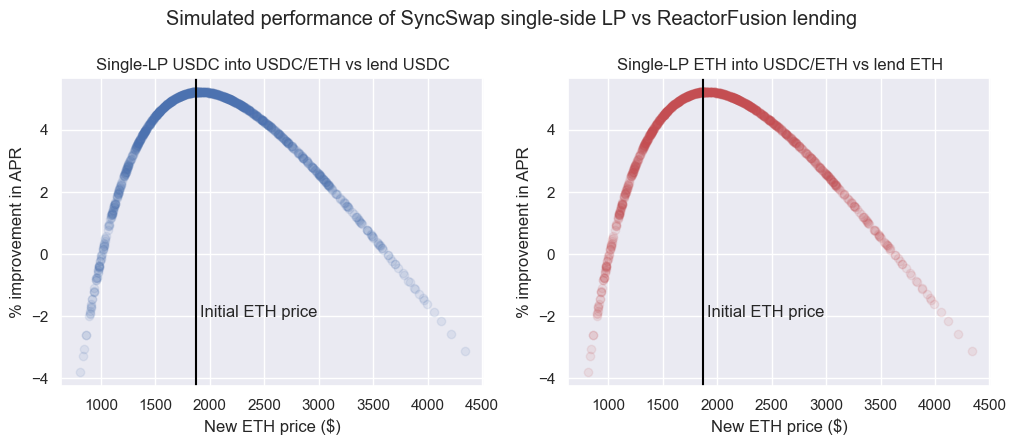

In [8]:
(fig, ax) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("Simulated performance of SyncSwap single-side LP vs ReactorFusion lending",
             y=1.05)
ax[0].scatter(new_prices, usdc_reactorfusion_outperformance_percentages, alpha=0.1, color='b')
ax[1].scatter(new_prices, eth_reactorfusion_outperformance_percentages, alpha=0.1, color='r')
ax[0].set_title("Single-LP USDC into USDC/ETH vs lend USDC")
ax[0].set_xlabel("New ETH price ($)")
ax[0].set_ylabel("% improvement in APR")

ax[1].set_title("Single-LP ETH into USDC/ETH vs lend ETH")
ax[1].set_xlabel("New ETH price ($)")
ax[1].set_ylabel("% improvement in APR")

ax[0].axvline(x=1875, color='black')
ax[0].text(1910, -2, 'Initial ETH price')
ax[1].axvline(x=1875, color='black')
ax[1].text(1910, -2, 'Initial ETH price')

Text(0.5, 1.0, 'Comparing $ performance across portfolios')

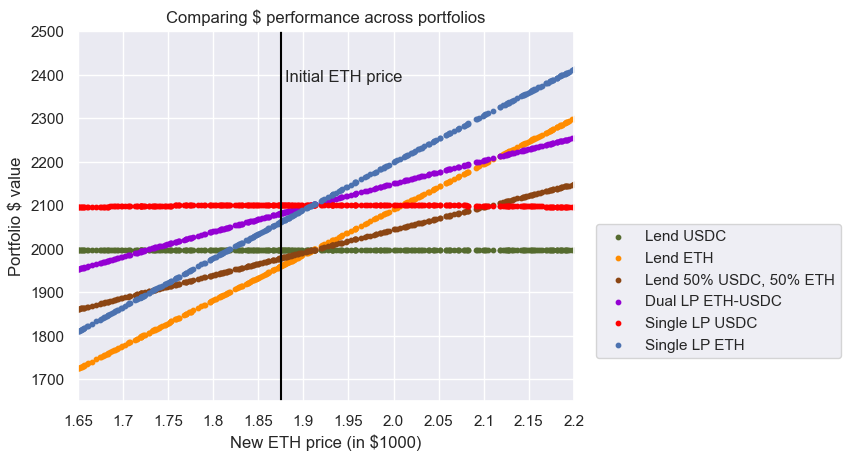

In [9]:
plt.scatter(new_prices, lending_usdc_dollar_value, label='Lend USDC', color='darkolivegreen', s=10)
plt.scatter(new_prices, lending_eth_dollar_value, label='Lend ETH', color='darkorange', s=10)
plt.scatter(new_prices, lending_equal_usdc_eth_dollar_value, label='Lend 50% USDC, 50% ETH', color='saddlebrown', s=10)

plt.scatter(new_prices, dual_lp_dollar_value, label='Dual LP ETH-USDC', color='darkviolet', s=10)
plt.scatter(new_prices, single_lp_dollar_value_usdc, label='Single LP USDC', color='red', s=10)
plt.scatter(new_prices, single_lp_dollar_value_eth, label='Single LP ETH', color='b', s=10)
plt.legend(bbox_to_anchor=(1.03, 0.5))
plt.xlabel("New ETH price (in $1000)")
plt.ylabel("Portfolio $ value")
plt.xlim(1650, 2200)
plt.ylim(1650, 2500)
ticks = np.arange(1650, 2201, 50)
_ = plt.xticks(ticks, [t/1000 for t in ticks])

plt.axvline(x=1875, color='black')
plt.text(1880, 2385, 'Initial ETH price')
plt.title("Comparing $ performance across portfolios")

Text(1910, 2, 'Initial ETH price')

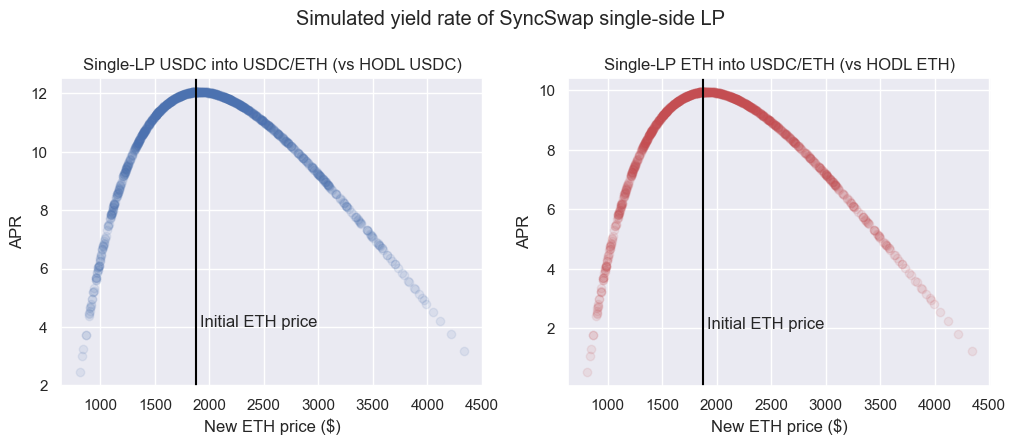

In [10]:
(fig, ax) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("Simulated yield rate of SyncSwap single-side LP",
             y=1.05)
ax[0].scatter(new_prices, usdc_yield_percentages, alpha=0.1, color='b')
ax[1].scatter(new_prices, eth_yield_percentages, alpha=0.1, color='r')
ax[0].set_title("Single-LP USDC into USDC/ETH (vs HODL USDC)")
ax[0].set_xlabel("New ETH price ($)")
ax[0].set_ylabel("APR")

ax[1].set_title("Single-LP ETH into USDC/ETH (vs HODL ETH)")
ax[1].set_xlabel("New ETH price ($)")
ax[1].set_ylabel("APR")

ax[0].axvline(x=1875, color='black')
ax[0].text(1910, 4, 'Initial ETH price')
ax[1].axvline(x=1875, color='black')
ax[1].text(1910, 2, 'Initial ETH price')

Text(0.5, 1.0, 'Comparing $ performance across portfolios')

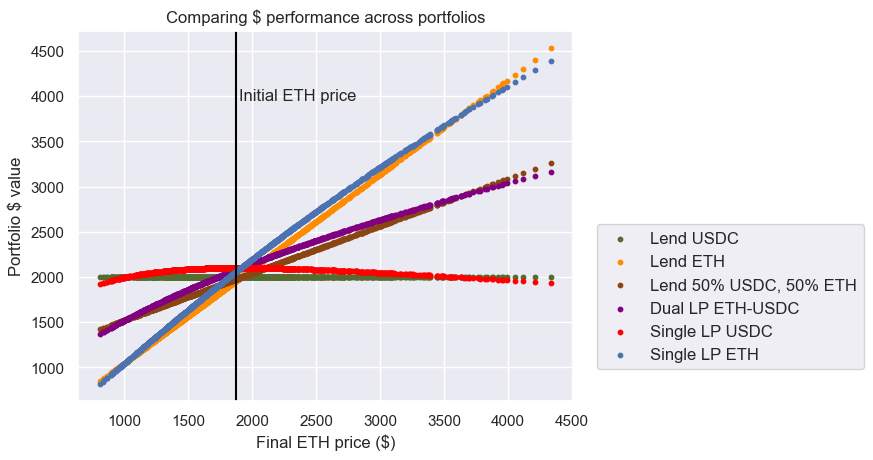

In [11]:
plt.scatter(new_prices, lending_usdc_dollar_value, label='Lend USDC', color='darkolivegreen', s=10)
plt.scatter(new_prices, lending_eth_dollar_value, label='Lend ETH', color='darkorange', s=10)
plt.scatter(new_prices, lending_equal_usdc_eth_dollar_value, label='Lend 50% USDC, 50% ETH', color='saddlebrown', s=10)

plt.scatter(new_prices, dual_lp_dollar_value, label='Dual LP ETH-USDC', color='purple', s=10)
plt.scatter(new_prices, single_lp_dollar_value_usdc, label='Single LP USDC', color='red', s=10)
plt.scatter(new_prices, single_lp_dollar_value_eth, label='Single LP ETH', color='b', s=10)
plt.legend(bbox_to_anchor=(1.03, 0.5), fontsize=12)
plt.xlabel("Final ETH price ($)")
plt.ylabel("Portfolio $ value")

plt.axvline(x=1875, color='black')
plt.text(1900, 3950, 'Initial ETH price')
plt.title("Comparing $ performance across portfolios")

Text(0.5, 1.0, 'Comparing $ performance across portfolios')

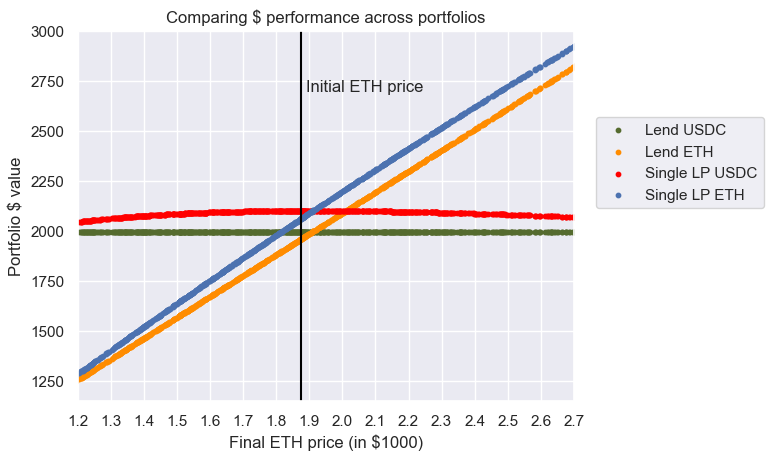

In [12]:
plt.scatter(new_prices, lending_usdc_dollar_value, label='Lend USDC', color='darkolivegreen', s=10)
plt.scatter(new_prices, lending_eth_dollar_value, label='Lend ETH', color='darkorange', s=10)

plt.scatter(new_prices, single_lp_dollar_value_usdc, label='Single LP USDC', color='red', s=10)
plt.scatter(new_prices, single_lp_dollar_value_eth, label='Single LP ETH', color='b', s=10)
plt.legend(bbox_to_anchor=(1.03, 0.5))
plt.xlabel("Final ETH price (in $1000)")
plt.ylabel("Portfolio $ value")
plt.xlim(1200, 2700)
plt.ylim(1150, 3000)
ticks = np.arange(1200, 2701, 100)
_ = plt.xticks(ticks, [t/1000 for t in ticks])

plt.axvline(x=1875, color='black')
plt.text(1890, 2700, 'Initial ETH price')
plt.title("Comparing $ performance across portfolios")